# Real Estate Data Modeling Notebook

This notebook loads and cleans real estate data, performs target encoding, removes outliers, and then builds several regression models. It also tunes the best performing model and uses SHAP for model interpretability.

### Requirements

Ensure you have installed the required packages:

```bash
pip install pandas numpy scikit-learn xgboost matplotlib shap
```

Also, please confirm that the file `realtor-data.zip.csv` is in the same directory as this notebook. If your data file is zipped, this notebook uses the `compression='zip'` argument when reading the file.

Baseline CV R^2 Scores:
Random Forest: 0.7064
XGBoost: 0.6735
Linear Regression: 0.5911

Best model: Random Forest


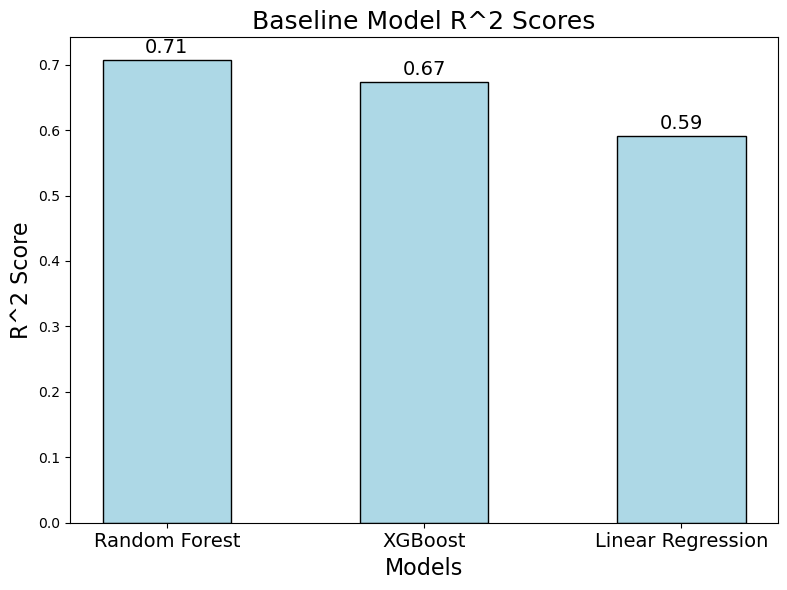

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# ----------------------------------------
# Load and clean data
# ----------------------------------------
# If your file is compressed, the 'compression' argument helps read it.
try:
    df = pd.read_csv("realtor-data.zip.csv")
except Exception as e:
    print("Error reading file as zip-compressed CSV. Attempting to read as a normal CSV...")
    print("Error details:", e)
    df = pd.read_csv("realtor-data.zip.csv")

# Remove columns that might not be present
df.drop(columns=["prev_sold_date", "status", "street", "brokered_by"], inplace=True, errors="ignore")
df.dropna(inplace=True)

# Exclude certain states
excluded_states = ['GUAM', 'DISTRICT OF COLUMBIA', 'NEW BRUNSWICK', 'PUERTO RICO', 'VIRGIN ISLANDS', 'PR']
df = df[~df["state"].str.upper().isin(excluded_states)]

# Ensure zip codes are strings
df["zip_code"] = df["zip_code"].astype(str)

# ----------------------------------------
# Target encoding
# ----------------------------------------
zip_means = df.groupby("zip_code")["price"].mean()
city_means = df.groupby("city")["price"].mean()
state_means = df.groupby("state")["price"].mean()

df["city_encoded"] = df["city"].map(city_means)
df["state_encoded"] = df["state"].map(state_means)

df.drop(columns=["city", "state"], inplace=True)

# ----------------------------------------
# Outlier removal
# ----------------------------------------
def remove_outliers(df, columns, threshold=1.5):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - threshold * IQR
        upper = Q3 + threshold * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

numeric_cols = ["price", "bed", "bath", "acre_lot", "house_size", "city_encoded", "state_encoded"]
df = remove_outliers(df, numeric_cols)

# ----------------------------------------
# Define features and target
# ----------------------------------------
features = ["bed", "bath", "acre_lot", "house_size", "city_encoded", "state_encoded"]
X = df[features]
y = df["price"]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ----------------------------------------
# Baseline CV for all models
# ----------------------------------------
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0),
    "Linear Regression": LinearRegression()
}

best_model_name = None
best_cv_score = -np.inf
cv_scores = {}  

print("Baseline CV R^2 Scores:")
for name, model in models.items():
    score = cross_val_score(model, X_scaled, y, cv=5, scoring='r2', n_jobs=-1).mean()
    cv_scores[name] = score
    print(f"{name}: {score:.4f}")
    if score > best_cv_score:
        best_model_name = name
        best_cv_score = score

print(f"\nBest model: {best_model_name}")

# ----------------------------------------
# Plot R^2 scores for baseline models
# ----------------------------------------
names = list(cv_scores.keys())
scores = list(cv_scores.values())
x = np.arange(len(names))
width = 0.5

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(x, scores, width, color='lightblue', edgecolor='black')
ax.set_xlabel("Models", fontsize=16)
ax.set_ylabel("R^2 Score", fontsize=16)
ax.set_title("Baseline Model R^2 Scores", fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(names, fontsize=14)

for i, score in enumerate(scores):
    ax.text(x[i], score + 0.005, f"{score:.2f}", ha='center', va='bottom', fontsize=14)

plt.tight_layout()
plt.show()




In [2]:

# ----------------------------------------
# Define hyperparameter spaces
# ----------------------------------------
param_grids = {
    "Random Forest": {
        'n_estimators': [100, 300, 500],
        'max_depth': [10, 30],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt', 'log2']
    },
    "XGBoost": {
        'n_estimators': [100, 300, 500],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.7, 1.0]
    }
}


In [3]:
# ----------------------------------------
# Tune only the best model
# ----------------------------------------
if best_model_name == "Random Forest":
    base_model = RandomForestRegressor(random_state=42)
elif best_model_name == "XGBoost":
    base_model = XGBRegressor(random_state=42, verbosity=0)
else:
    base_model = LinearRegression()

if best_model_name in param_grids:
    search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_grids[best_model_name],
        n_iter=10,
        cv=3,
        scoring="r2",
        verbose=1,
        n_jobs=-1
    )
    search.fit(X_scaled, y)
    best_model = search.best_estimator_
    print("\nBest parameters found:", search.best_params_)
else:
    base_model.fit(X_scaled, y)
    best_model = base_model



Fitting 3 folds for each of 10 candidates, totalling 30 fits


python(22265) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22266) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/opt/anaconda3/envs/CSE6242/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
python(22334) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22335) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22349) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22371) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



Best parameters found: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30}


In [4]:
# ----------------------------------------
# Final evaluation
# ----------------------------------------
y_pred = best_model.predict(X_scaled)
rmse = mean_squared_error(y, y_pred, squared=False)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)
mape = np.mean(np.abs((y - y_pred) / y)) * 100

print(f"\nFinal Model: {best_model_name}")
print(f"Train RMSE: {rmse:.2f}")
print(f"Train MAE: {mae:.2f}")
print(f"Train R^2: {r2:.4f}")
print(f"Train MAPE: {mape:.2f}%")




Final Model: Random Forest
Train RMSE: 36050.80
Train MAE: 24320.24
Train R^2: 0.9614
Train MAPE: 578.89%


Using TreeExplainer for Random Forest

Generating SHAP summary plot for model interpretation...


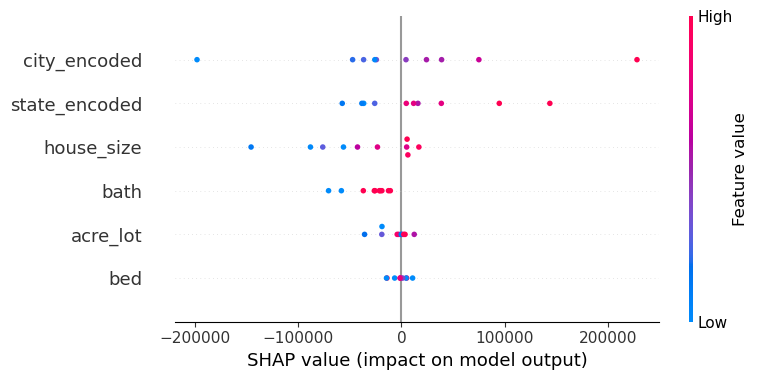

In [5]:
# ----------------------------------------
# SHAP Explanation (on sample)
# ----------------------------------------
import shap

sample_size = min(10, X.shape[0])
X_sample = pd.DataFrame(X_scaled, columns=features).sample(sample_size, random_state=42)

if best_model_name in ["Random Forest", "XGBoost"]:
    print("Using TreeExplainer for Random Forest")
    explainer = shap.TreeExplainer(best_model)
elif best_model_name == "Linear Regression":
    explainer = shap.LinearExplainer(best_model, X_sample)
else:
    explainer = shap.KernelExplainer(best_model.predict, X_sample)

shap_values = explainer.shap_values(X_sample)

print("\nGenerating SHAP summary plot for model interpretation...")
shap.summary_plot(shap_values, X_sample, feature_names=features)